In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SABR_class
from SABR_class import SABR

# Reading data

In [2]:
fname = 'deribit_data.csv'
df = pd.read_csv(fname, index_col=[0])

In [3]:
df.head()

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,...,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho
0,deribit,ETH-30DEC22-1300-P,1661990399996000,1661990400002270,put,1300,1672387200000000,8046.0,0.1375,0.1465,...,102.64,0.1478,102.05,ETH-30DEC22,1523.1100,-0.28662,0.00038,2.97707,-1.26233,-2.18163
1,deribit,ETH-30DEC22-15000-P,1661990400007000,1661990400011122,put,15000,1672387200000000,0.0,NaN,NaN,...,NaN,8.8488,135.30,ETH-30DEC22,1523.1100,-0.99470,0.00001,0.13314,-0.07485,-49.43078
2,deribit,ETH-31MAR23-4500-P,1661990400048000,1661990400061948,put,4500,1680249600000000,16.0,1.2695,NaN,...,200.16,1.9889,97.66,ETH-31MAR23,1525.6200,-0.86084,0.00020,2.57325,-0.59455,-25.17323
3,deribit,ETH-25NOV22-1600-P,1661990400063000,1661990400073423,put,1600,1669363200000000,273.0,0.2170,0.2205,...,101.29,0.2235,101.04,SYN.ETH-25NOV22,1524.3589,-0.44230,0.00053,2.90962,-1.72252,-2.37288
4,deribit,ETH-25NOV22-1600-P,1661990400096000,1661990400106456,put,1600,1669363200000000,273.0,0.2170,0.2205,...,101.29,0.2235,101.04,SYN.ETH-25NOV22,1524.3589,-0.44230,0.00053,2.90962,-1.72252,-2.37288


# Select options on BTC

In [4]:
def select_data(df: pd.DataFrame):
    btc_ind = [symbol.startswith('BTC') for symbol in df.underlying_index]

    columns_to_drop = ['exchange', 'symbol', 'local_timestamp', 'underlying_index',
                       'delta', 'gamma', 'vega', 'theta', 'rho']

    btc = df[btc_ind].reset_index(drop=True).drop(columns_to_drop, axis=1)
    btc['tau'] = (btc.expiration - btc.timestamp) / 1e6 / 3600 / 24 / 365
    btc['days'] = (btc['tau'] * 365).astype(int)

    K = btc.strike_price.values
    F = btc.underlying_price.values

    payoff = np.maximum(F - K, 0.0)
    payoff[btc.type == 'put'] = np.maximum(K - F, 0.0)[btc.type == 'put']

    btc["payoff"] = payoff

    btc['mid_price'] = 0.5 * (btc.ask_price + btc.bid_price)
    btc_grouped = btc.groupby(['type', 'expiration', 'strike_price'])\
        .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)
    put = btc_grouped[btc_grouped.type == 'put'].drop(
        ['type'], axis=1).reset_index(drop=True)

    call = btc_grouped[btc_grouped.type == 'call'].drop(
        ['type'], axis=1).reset_index(drop=True)

    return put, call

In [5]:
put, call = select_data(df)

In [6]:
put.head()

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1662105600000000,13000,20.5,0.0010,NaN,NaN,NaN,0.0005,34.0,309.42,0.0,127.05,20087.59,0.003641,1,0.0,NaN
1,1662105600000000,14000,38.4,0.0005,NaN,NaN,NaN,0.0005,42.5,261.68,0.0,127.05,20087.59,0.003641,1,0.0,NaN
2,1662105600000000,15000,130.0,0.0005,NaN,NaN,NaN,0.0005,39.0,216.69,0.0,120.27,20087.59,0.003641,1,0.0,NaN
3,1662105600000000,16000,578.2,0.0005,NaN,NaN,NaN,0.0010,89.0,193.13,0.0,101.18,20087.59,0.003641,1,0.0,NaN
4,1662105600000000,17000,579.9,0.0005,NaN,NaN,NaN,0.0005,11.0,132.83,0.0,95.26,20087.59,0.003641,1,0.0,NaN


In [7]:
call.head()

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1662105600000000,13000,0.0,NaN,0.2425,3.0,NaN,0.4480,3.0,500.0,0.3528,127.05,20087.35,0.003641,1,7087.35,0.34525
1,1662105600000000,14000,0.0,NaN,0.1925,3.0,NaN,0.3980,3.0,500.0,0.3031,127.05,20087.92,0.003641,1,6087.92,0.29525
2,1662105600000000,15000,0.0,NaN,0.1430,3.0,NaN,0.3485,3.0,500.0,0.2533,120.27,20087.35,0.003641,1,5087.35,0.24575
3,1662105600000000,16000,0.0,NaN,0.0930,3.0,NaN,0.2985,3.0,500.0,0.2035,101.18,20087.92,0.003641,1,4087.92,0.19575
4,1662105600000000,17000,0.0,NaN,0.0435,3.0,NaN,0.2490,3.0,500.0,0.1537,95.26,20087.35,0.003641,1,3087.35,0.14625


# Volatility smile

In [8]:
days = set(call.days.values)
days

{1, 8, 29, 57, 120, 211, 302}

In [9]:
day = 120
call_ = call[call.days == day]

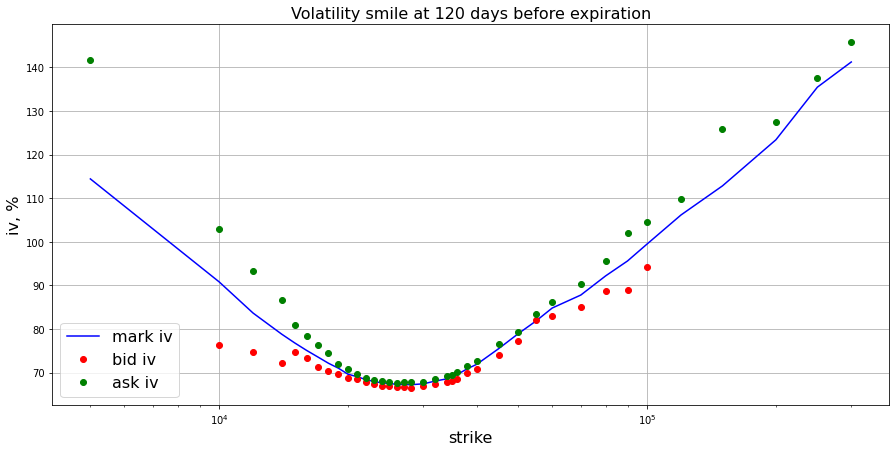

In [10]:
plt.figure(figsize=(15, 7))
plt.title(f"Volatility smile at {day} days before expiration", fontsize=16)
plt.semilogx(call_.strike_price.values, call_.mark_iv, '-b', label='mark iv')
plt.semilogx(call_.strike_price.values, call_.bid_iv, 'or', label='bid iv')
plt.semilogx(call_.strike_price.values, call_.ask_iv, 'og', label='ask iv')
plt.ylabel("iv, %", fontsize=16)
plt.xlabel("strike", fontsize=16)
plt.legend(fontsize=16)
plt.grid()

# Calibration of volatility surface

### We'll calibrate volatility surface using only OTM options and then we'll test it on whole dataset

In [11]:
def OTM_data_from_df(df: pd.DataFrame):
    """
    Function extracts OTM data from dataframe

    Parameters
        ----------
            df: pd.DataFrame 
            dataframe of market data

    Returns:
        ----------
            C: np.ndarray
            option prices 
            iv: np.ndarray
            implied vol
            K: np.ndarray
            strikes
            F: np.ndarray
            underlying prices
            T: np.ndarray
            expiration times

    """

    ind = (df.payoff == 0.0) & (~np.isnan(df.mid_price).values)
    df_ = df[ind].copy().reset_index(drop=True)

    F = df_.underlying_price.values
    K = df_.strike_price.values
    T = df_.tau.values

    iv = 0.5 * (df_.ask_iv.values + df_.bid_iv.values) / 100.0
    C = df_.mid_price.values * F

    return C, iv, K, F, T


def get_calibration_data(put: pd.DataFrame, call: pd.DataFrame):
    """
    Function extracts OTM data from calls and puts and concatenates it for calibration

    Parameters
        ----------
            put: pd.DataFrame
            call: pd.DataFrame   

    Returns:
        ----------
            C: np.ndarray
            option prices 
            iv: np.ndarray
            implied vol
            K: np.ndarray
            strikes
            F: np.ndarray
            underlying prices
            T: np.ndarray
            expiration times
    """
    data_call = np.stack(OTM_data_from_df(call))
    data_put = np.stack(OTM_data_from_df(put))
    data = np.concatenate((data_call, data_put), axis=-1)
    c, iv, K, F, T = data
    
    return c, iv, K, F, T

In [12]:
X, iv, K, F, T = get_calibration_data(put, call)
weights = np.ones_like(X)
weights = weights / np.sum(weights)

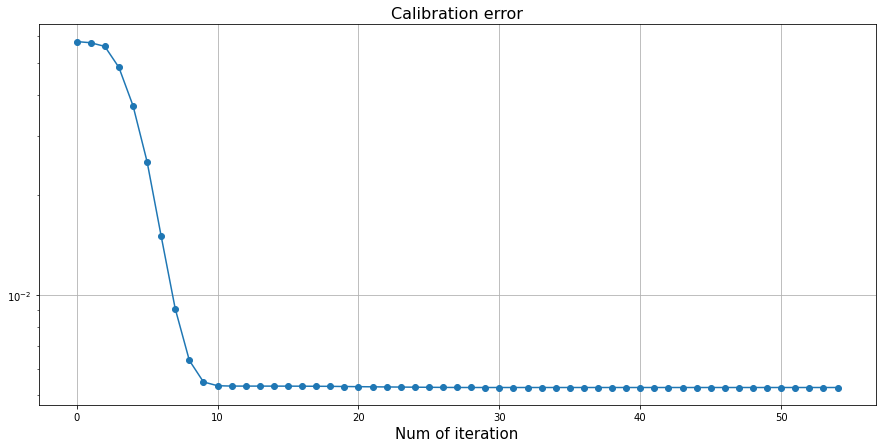

In [13]:
sabr_model = SABR()
result = sabr_model.fit_iv(iv, K, F, T, Niter=100, weights=weights)
plt.figure(figsize=(15, 7))
plt.title("Calibration error", fontsize=16)
plt.semilogy(result['objective'], '-o')
plt.xlabel("Num of iteration", fontsize=15)
plt.grid()

In [14]:
print(f"alpha: {sabr_model.sabr_params[0].round(6)}")
print(f"beta: {sabr_model.sabr_params[1].round(6)}")
print(f"rho: {sabr_model.sabr_params[2].round(6)}")
print(f"v: {sabr_model.sabr_params[3].round(6)}")

alpha: 0.71555
beta: 0.999999
rho: -0.305836
v: 1.017949


# Plotting option prices

In [15]:
def plot_option_price(call: pd.DataFrame, put: pd.DataFrame, day: float):
    plt.figure(figsize=(15, 7))

    call_ = call[call.days == day]
    put_ = put[put.days == day]

    K = call_.strike_price.values
    F = call_.underlying_price.values
    T = call_.tau.values

    C_predict = sabr_model.predict_call_price(K, F, T)
    C_mid = call_.mid_price.values * F
    C_mark = call_.mark_price.values * F
    error_call = 100 * \
        np.linalg.norm(C_mark - C_predict) / np.linalg.norm(C_mark)

    plt.semilogx(K, C_predict, '-r', label='call predicted')
    plt.semilogx(K, C_mid,   'ro', label='call market data')

    K = put_.strike_price.values
    F = put_.underlying_price.values
    T = put_.tau.values

    P_predict = sabr_model.predict_put_price(K, F, T)
    P_mid = put_.mid_price.values * F
    P_mark = put_.mark_price.values * F
    error_put = 100 * \
        np.linalg.norm(P_mark - P_predict) / np.linalg.norm(P_mark)

    plt.semilogx(K, P_predict, '-b', label='put predicted')
    plt.semilogx(K, P_mid,   'bo', label='put market data')

    plt.legend(fontsize=15)
    plt.title(
        f'Day to expiration {day}, error={(error_call + error_put):.4f}%', fontsize=16)
    plt.grid()

    plt.xlabel("Strike", fontsize=16)
    plt.ylabel("Option price", fontsize=16)

In [16]:
days

{1, 8, 29, 57, 120, 211, 302}

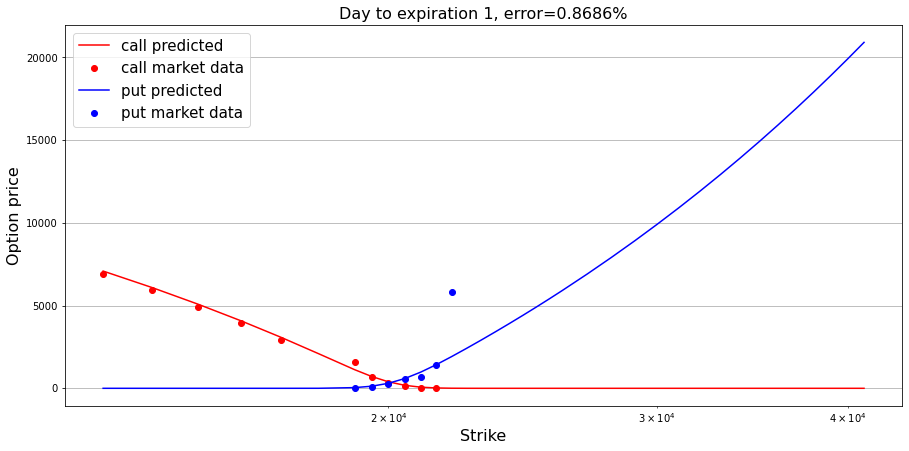

In [17]:
plot_option_price(call, put, 1)

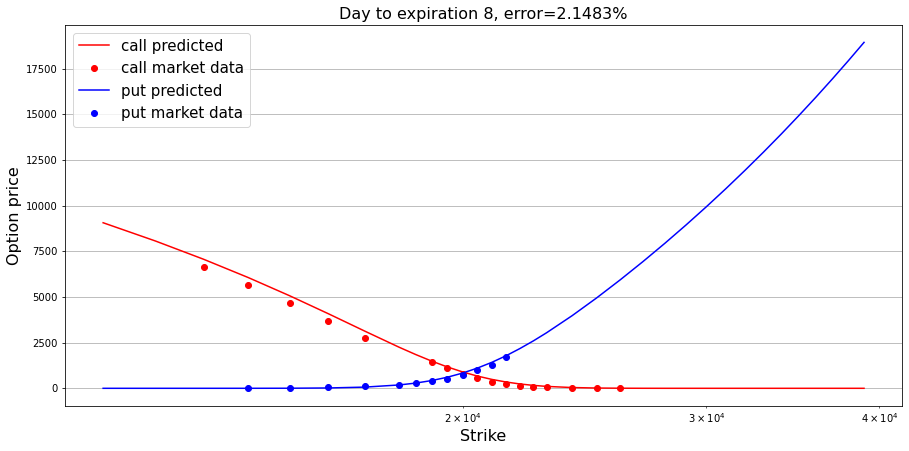

In [18]:
plot_option_price(call, put, 8)

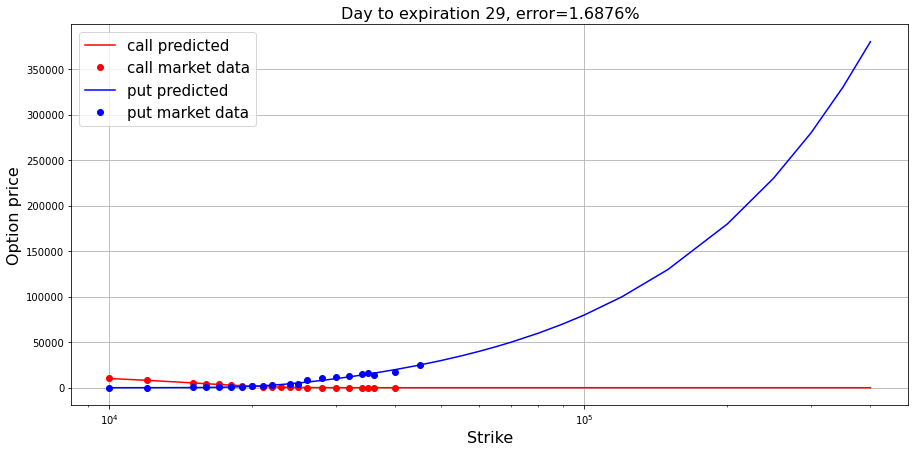

In [19]:
plot_option_price(call, put, 29)

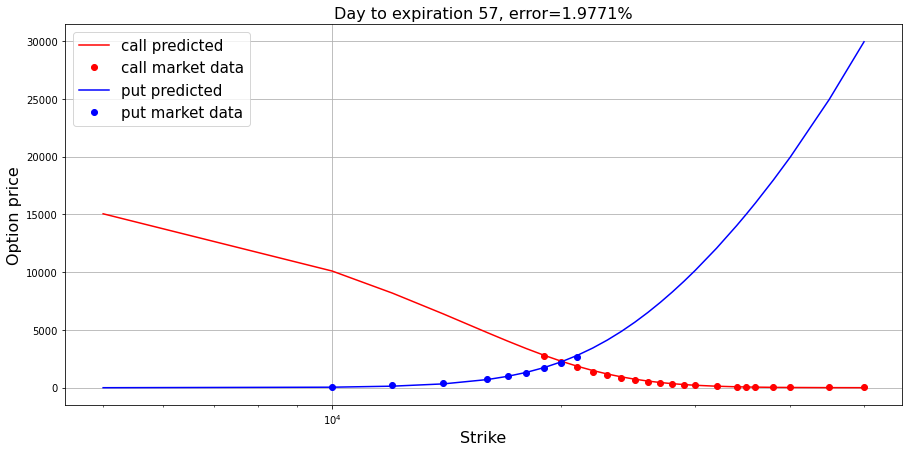

In [20]:
plot_option_price(call, put, 57)

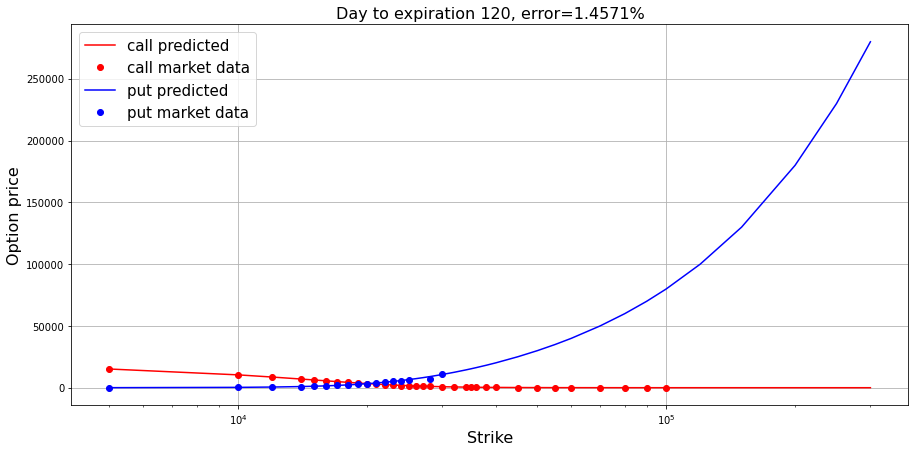

In [21]:
plot_option_price(call, put, 120)

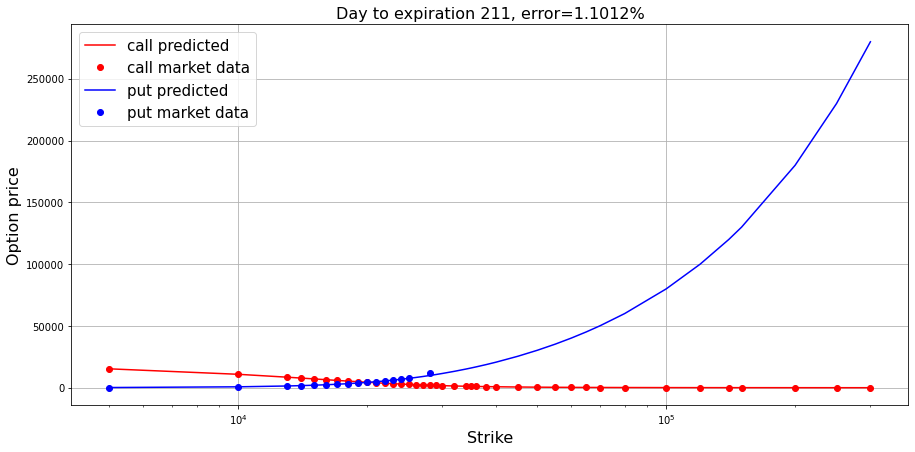

In [22]:
plot_option_price(call, put, 211)

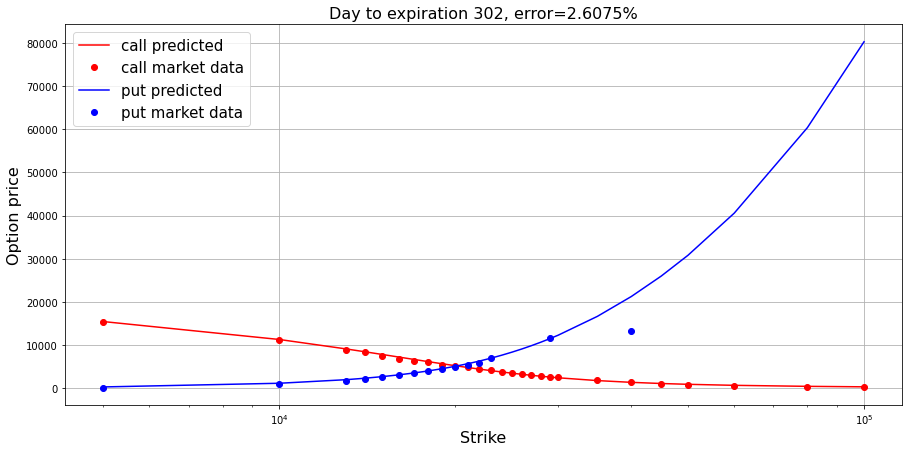

In [23]:
plot_option_price(call, put, 302)